# Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
np.random.seed(13)

In [2]:
# Download data in google colab, no need to run this in your laptops

# Just in case...
!rm -rf ml-latest-small*
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2019-04-06 05:44:20--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.10MB/s    in 0.3s    

2019-04-06 05:44:20 (3.10 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


# Load data

In [0]:
rating_data = pd.read_csv("ml-latest-small/ratings.csv", index_col='timestamp', parse_dates=['timestamp'], date_parser = lambda x: datetime.datetime.fromtimestamp(int(x)))
movie_data = pd.read_csv("ml-latest-small/movies.csv", index_col='movieId')

## Process data
**Assumption**: one rating = one request

In [27]:
del rating_data['userId']
rating_data.head()

,movieId,rating
timestamp,,
2000-07-30 18:45:03,1,4.0
2000-07-30 18:20:47,3,4.0
2000-07-30 18:37:04,6,4.0
2000-07-30 19:03:35,47,5.0
2000-07-30 18:48:51,50,5.0


In [28]:
del movie_data['title']
movie_data.head()

,genres
movieId,
1,Adventure|Animation|Children|Comedy|Fantasy
2,Adventure|Children|Fantasy
3,Comedy|Romance
4,Comedy|Drama|Romance
5,Comedy


In [0]:
def assign_class(n_req, total_req):
    """
    assign class based on the no. of request received
    """
    
    # top 1% of the day are Class 1
    if n_req > 0.01 * total_req:
        return 1
    # top 0.5% of the day are Class 2
    elif n_req > 0.005 * total_req:
        return 2
    # top 0.01% of the day are Class 3
    elif n_req > 0.001 * total_req:
        return 3
    # rest are Class 4
    else:
        return 4

In [0]:
def group_movies(daywise_group):
    """
    add request probablity to input pandas DataFrame
    
    :param daywise_group: a DataFrame containing movieId and corresponding ratings for a single day.
    """

    df = daywise_group.groupby("movieId").count()   
    # `rating` column now holds the no. of requests, so rename the column to avoid confusion
    df.rename(columns={"rating":"req"}, inplace=True)
    df['totalReq'] = daywise_group.shape[0]
    # request probablity for that day
    df['reqProb'] = daywise_group.groupby("movieId").count()['rating'] / df['totalReq']
    return df

In [34]:
grouped_by_movie = rating_data.resample("1y").apply(group_movies)
grouped_by_movie['class'] = grouped_by_movie[['req', 'totalReq']].apply(lambda x:assign_class(x['req'], x['totalReq']), axis=1)
grouped_by_movie.reset_index(level='movieId', inplace=True)
grouped_by_movie.head()

,movieId,req,totalReq,reqProb,class
timestamp,,,,,
1996-12-31,1,33,6040,0.005464,2
1996-12-31,2,26,6040,0.004305,3
1996-12-31,3,12,6040,0.001987,3
1996-12-31,4,5,6040,0.000828,4
1996-12-31,5,18,6040,0.002980,3


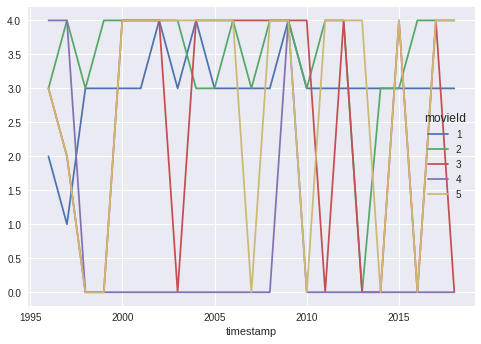

In [50]:
grouped_by_movie.pivot(columns='movieId', values='class').fillna(0).iloc[:100,:5].plot()

### Add genres

In [40]:
grouped_by_movie = pd.merge(grouped_by_movie.reset_index(), movie_data.reset_index())
grouped_by_movie.set_index('timestamp', inplace = True)
grouped_by_movie.head()

,movieId,req,totalReq,reqProb,class,genres
timestamp,,,,,,
1996-12-31,1,33,6040,0.005464,2,Adventure|Animation|Children|Comedy|Fantasy
1997-12-31,1,22,1916,0.011482,1,Adventure|Animation|Children|Comedy|Fantasy
1998-12-31,1,1,507,0.001972,3,Adventure|Animation|Children|Comedy|Fantasy
1999-12-31,1,9,2439,0.003690,3,Adventure|Animation|Children|Comedy|Fantasy
2000-12-31,1,18,10061,0.001789,3,Adventure|Animation|Children|Comedy|Fantasy


In [48]:
# Convert genres(str) to a binary matrix
# because string are good for humans but
# machines like numbers!
from sklearn.preprocessing import MultiLabelBinarizer
splitted = grouped_by_movie.apply(lambda x:x['genres'].split("|"), axis=1)
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(splitted)

genre_df = pd.DataFrame(genre_matrix)

with_genre = pd.merge(grouped_by_movie.reset_index(), genre_df.reset_index(), left_index=True, right_index=True)
del with_genre['genres'], with_genre['index']

# shift class column to the end
with_genre = with_genre[ list(filter(lambda x: x!='class', with_genre.columns)) + ['class']]

with_genre.set_index('timestamp', inplace = True)
with_genre.head()

,movieId,req,totalReq,reqProb,0,1,2,3,4,5,...,11,12,13,14,15,16,17,18,19,class
timestamp,,,,,,,,,,,,,,,,,,,,,
1996-12-31,1,33,6040,0.005464,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2
1997-12-31,1,22,1916,0.011482,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1998-12-31,1,1,507,0.001972,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,3
1999-12-31,1,9,2439,0.003690,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,3
2000-12-31,1,18,10061,0.001789,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,movieId,req,reqProb,0,1,2,3,4,5,6,...,12,13,14,15,16,17,18,19,class,Y
timestamp,,,,,,,,,,,,,,,,,,,,,
1996-12-31,356,69,0.011424,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,3
1997-12-31,356,5,0.002610,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,3,2
1998-12-31,356,3,0.005917,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,2,3
1999-12-31,356,10,0.004100,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,3,3
2000-12-31,356,23,0.002286,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,3,3


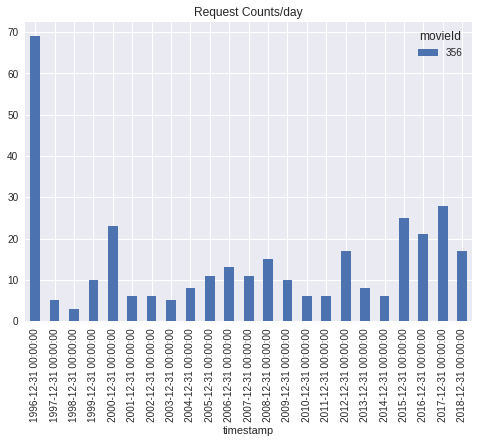

In [51]:
# We are selecting a single movie here, selecting 
# multiple movies will yield bad results because 
# of difference in data points.
movie_history = with_genre[with_genre['movieId'] == 356]
movie_history['Y'] = np.roll(movie_history['class'], -1)
movie_history.pivot(columns='movieId', values='req').plot(kind='bar', title="Request Counts/day")
del movie_history['totalReq']
movie_history.head()

# Crunching numbers!

In [17]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
# One-hot-encode classes
preprocess = make_column_transformer([OneHotEncoder(categories=[np.array([1,2,3,4])]), ['class', 'Y']])
values = movie_history.values
#print(values)
one_hot_encoded = np.concatenate((list(map(lambda x:np.eye(4)[x-1], values[:,23].astype('int')) ),
               list(map(lambda x:np.eye(4)[x-1], values[:,24].astype('int')))), axis=1)
values = np.concatenate((movie_history.values[:,:23], one_hot_encoded), axis=1)

# Scale 
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)
scaled_values.shape


(23, 31)

## Make X and Y

In [52]:
n_input_cols = 27
n_output_cols = 4
X = scaled_values[:,:n_input_cols]
y = scaled_values[:,n_input_cols:]
# reshape
X = X.reshape(X.shape[0], 1, n_input_cols)
y = y.reshape(y.shape[0], 1, n_output_cols)
print(X.shape)
print(y.shape)

(23, 1, 27)
(23, 1, 4)


## train_test_split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Make Model

In [55]:
from keras.models import Sequential
from keras.layers import Dropout, LSTM, BatchNormalization, TimeDistributed, Dense, Activation
model = Sequential()
model.add(BatchNormalization(input_shape=(1,X_train.shape[2])))
model.add(LSTM(4, return_sequences=True))
model.add(LSTM(1, dropout=0.2, return_sequences=True))
model.add(TimeDistributed(Dense(y_train.shape[2])))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 1, 27)             108       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 4)              512       
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 1)              24        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 4)              8         
_________________________________________________________________
activation_3 (Activation)    (None, 1, 4)              0         
Total params: 652
Trainable params: 598
Non-trainable params: 54
_________________________________________________________________


In [56]:
history = model.fit(X_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
15/15 [==============================] - 3s 175ms/step - loss: 1.3856 - acc: 0.0667
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3830 - acc: 0.3333
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3809 - acc: 0.4000
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3781 - acc: 0.7333
Epoch 5/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3750 - acc: 0.7333
Epoch 6/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3720 - acc: 0.8667
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3693 - acc: 0.8667
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3665 - acc: 0.8667
Epoch 9/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3638 - acc: 0.9333
Epoch 10/10
15/15 [==============================] - 0s 1ms/step - loss: 1.3606 - acc: 0.9333


In [57]:
score, acc = model.evaluate(X_test, y_test, batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

8/8 [==============================] - 1s 88ms/step
Test score: 1.3634483814239502
Test accuracy: 0.875


In [92]:
def predict(input_array):
    dat = np.concatenate((input_array, [[0]*n_output_cols]*input_array.shape[0]), axis=1)
    dat = scaler.transform(dat)[:,:n_input_cols]
    dat = dat.reshape(dat.shape[0], 1, n_input_cols)
    predicted = model.predict(dat)

    predicted = predicted.reshape(1,n_output_cols)
    x = np.concatenate(([[0]*n_input_cols]*input_array.shape[0], predicted), axis=1)
    return scaler.inverse_transform(x)[:,n_input_cols:]

predict(np.array([
    [356,56,0.156] + list(mlb.transform([['Comedy', 'Drama', 'Romance', 'War']])[0]) + [1,0,0,0]
]))

array([[0.26705664, 0.24057522, 0.25555053, 0.23681757]])